In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [14]:
import os

import bk.load
import bk.compute
import bk.plot
import bk.signal

import numpy as np
import pandas as pd

import scipy.signal
import scipy.stats as ss
import scipy.io

import matplotlib.pyplot as plt
import matplotlib as mpl
import neuroseries as nts
import basefunction.vBaseFunctions3
from tqdm import tqdm
import itertools

import pickle
import seaborn as sns

In [3]:
def save_fig(folder_path,name):
    import os
    old_path = os.getcwd()
    os.chdir(folder_path)
    plt.savefig(name)
    os.chdir(old_path)

def load_ripples():
    ripples_ = scipy.io.loadmat(f'{bk.load.session}-RippleFiring.mat')['ripples']['allsws'][0][0]
#     ripples_ = pd.DataFrame(data = ripples,columns=['start','peak','stop'])
    
    columns = ['start','peak','stop']
    
    ripples = {}
    for i,c in zip(range(ripples_.shape[1]),columns):
        ripples.update({c:nts.Ts(ripples_[:,i],time_units='s')})
    return ripples

def poissonTest(baseRate,counts,time):
    eps = np.spacing(1)
    
    lam = baseRate*time
    
    pInc = 1 - ss.poisson.cdf(counts,lam)
    pDec = ss.poisson.cdf(counts,lam)
    surprise = np.log((pDec+eps)/(pInc + eps))
    return pInc,pDec,surprise

def psth(neurons,stimulus,binSize,win,average = True):
    if isinstance(neurons,nts.time_series.Tsd): 
        neurons = np.array(neurons,'object')
    winLen = int((win[1] - win[0])/binSize)
    window = np.arange(winLen,dtype = int)-int(winLen/2)
    stim_bin = (stimulus/binSize).astype('int')
    t,binned = bk.compute.binSpikes(neurons,binSize,start = 0, stop = stimulus[-1]+win[-1])
    psth = np.empty((stimulus.size,len(neurons),winLen))
    
    for i,t in tqdm(enumerate(stim_bin)):
        psth[i] = binned[:,t+window]
    if average:    
        psth = np.mean(psth,0).T
    t = window*binSize
    return t,psth

# def correlogram(neuron1,neuron2,binSize,win):

def ripple_psth(path):  
    
    win = [-0.5,0.5]
    binSize = 0.001
    
    
    bk.load.current_session(path)
    ripples = load_ripples()
    
    neurons,metadata = bk.load.loadSpikeData(bk.load.path)
    
    ripples_ = ripples['peak'].as_units('s').index.values
    t,psth_ = psth(neurons,ripples_,binSize,win)
    
    states = bk.load.states()
    states.update({'ripples':nts.IntervalSet(ripples['start'].times(),ripples['stop'].times())})
    states.update({'outside_ripples':states['sws'].set_diff(nts.IntervalSet(states['ripples'].start-200_000,states['ripples'].end+200_000,force_no_fix=True)).drop_short_intervals(1)})
    
    
    
    pInc = np.empty(len(neurons))
    pDec = np.empty(len(neurons))
    surprise = np.empty(len(neurons))
    for i,n in enumerate(neurons):
        baseRate = len(n.restrict(states['outside_ripples']))/states['outside_ripples'].tot_length(time_units = 's')
        count = len(n.restrict(states['ripples']))
        time = states['ripples'].tot_length(time_units = 's')
        
        pInc[i],pDec[i],surprise[i] = poissonTest(baseRate,count,time)
    
    stats = pd.DataFrame(np.array([pInc,pDec,surprise]).T,columns=['pInc','pDec','surprise'])
    
    metadata = pd.concat([metadata,stats],1) 
    
    print(metadata)
    return t,psth_,metadata

In [4]:
def ripple_psth_slow(path):
    nbins = 100
    
    
    bk.load.current_session(path)
    ripples = load_ripples()
    neurons,metadata = bk.load.loadSpikeData(bk.load.path)

    win = [-0.5,0.5]
    n_neurons = len(neurons)
    
    peth = np.empty((len(ripples['peak'].as_units('s').index),nbins,n_neurons))
    
    for i,ripple_time in tqdm(enumerate(ripples['peak'].as_units('s').index)):
        t,binned = bk.compute.binSpikes(neurons,nbins=nbins,start = ripple_time+win[0],stop = ripple_time+win[1])
        peth[i,:] = binned.T
    
    
    states = bk.load.states()
    states.update({'ripples':nts.IntervalSet(ripples['start'].times(),ripples['stop'].times())})
    states.update({'outside_ripples':states['sws'].set_diff(nts.IntervalSet(states['ripples'].start-200_000,states['ripples'].end+200_000,force_no_fix=True))})
    
    pInc = np.empty(len(neurons))
    pDec = np.empty(len(neurons))
    surprise = np.empty(len(neurons))
    for i,n in enumerate(neurons):
        baseRate = len(n.restrict(states['outside_ripples']))/states['outside_ripples'].tot_length(time_units = 's')
        count = len(n.restrict(states['ripples']))
        time = states['ripples'].tot_length(time_units = 's')
        
        pInc[i],pDec[i],surprise[i] = poissonTest(baseRate,count,time)
    
    stats = pd.DataFrame(np.array([pInc,pDec,surprise]).T,columns=['pInc','pDec','surprise'])
    
    
    return t,peth,metadata,stats

In [48]:
ripples_psth_10ms = np.load('/home/billel/pCloudDrive/Data/ripples_psth/ripples_psth_10ms.npy',allow_pickle = True).item()

In [54]:
ripples_psth_1ms = np.load('/home/billel/pCloudDrive/Data/ripples_psth/ripples_psth_1ms.npy',allow_pickle = True).item()

In [368]:
# batch = bk.load.batch(ripple_psth)
batch = ripples_psth_1ms
psthall = np.hstack([batch[s][1] for s in batch])
metaall = pd.concat([batch[s][2] for s in batch])
temps = batch['Rat08-20130708'][0]

In [142]:
win = [-0.5,0.5]
binSize = 0.005

bk.load.current_session()
ripples = load_ripples()

neurons,metadata = bk.load.loadSpikeData(bk.load.path)

ripples_ = ripples['peak'].as_units('s').index.values
t,psth_ = psth(neurons,ripples_,binSize,win,full = True)

FileNotFoundError: [Errno 2] No such file or directory: 'Z:/All-Rats/Billel/session_indexing.csv'

In [281]:
# os.mkdir('figs')
os.chdir('figs')

In [155]:
%matplotlib inline

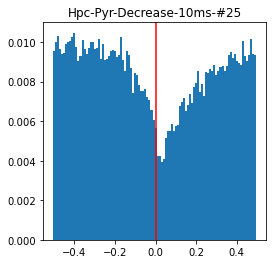

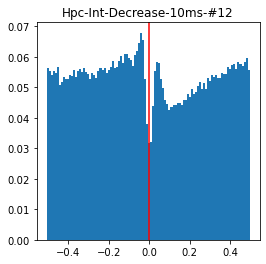

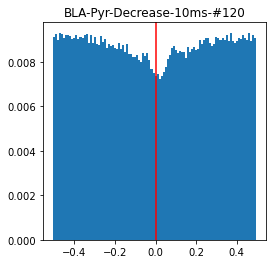

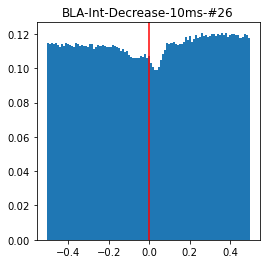

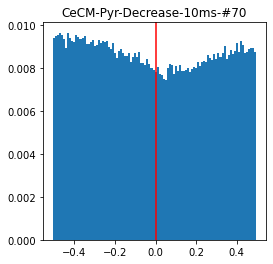

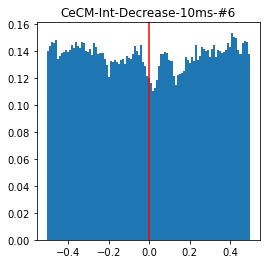

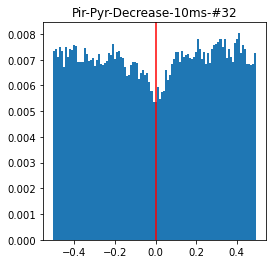

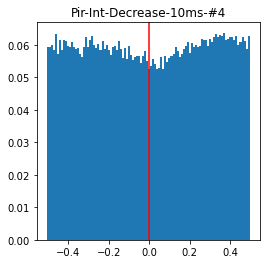

In [290]:
stru = ['Hpc','BLA','CeCM','Pir']
types = ['Pyr','Int']

for s,t in itertools.product(stru,types):
    psth = psthall[:,(metaall.Region == s) & (metaall.Type == t) & (metaall.pDec < 0.001)]
    
    n = len(psth.T)
    plt.figure(figsize= (4,4))
    plt.bar(temps,np.mean(psth,1),temps[1]-temps[0])
    plt.axvline(0,color = 'red')
#     plt.ylim(-2,10)
    plt.title(f'{s}-{t}-Decrease-10ms-#{n}')
    plt.savefig(f'{s}-{t}-Decrease-10ms-#{n}.svg')


In [209]:
%matplotlib inline

In [367]:
temps = batch['Rat08-20130710'][0]
a = np.unique(metaall.Region)
b = ['Pyr','Int']

@interact(stru = a,types = b,i = (0,200,1))
def plot(stru,types,i):
    mask = (metaall.pInc < 0.001) & (metaall.Region == stru) & (metaall.Type == types)
    mask = list(mask)
    psth = psthall[:,np.where(mask)[0]]
    meta = metaall[mask]

    zscore_p = scipy.stats.zscore(psth[:,i])
    g = scipy.signal.gaussian(100,1)
    g = g/np.sum(g)
    smooth_p = np.convolve(zscore_p,g,'same')

    plt.figure(figsize = (12,4))
    plt.title(f'Rat : {meta.Rat.iloc[i]} Day : {meta.Day.iloc[i]} Shank : {meta.Shank.iloc[i]} Id :{meta.Id.iloc[i]}')
    plt.bar(temps,zscore_p,temps[1]-temps[0])
#     plt.bar(temps, psth[:,i],temps[1]-temps[0])
    plt.plot(temps,smooth_p,'r--')



interactive(children=(Dropdown(description='stru', options=('BLA', 'BLV', 'BMA', 'BMP', 'CPu', 'CeCM', 'DEn', …

In [215]:
os.getcwd()

'/home/billel/Documents/Python/Amy-Hpc-sleep-dynamics-python'

In [211]:
np.sum(metaall.Region == 'BLA')

884

In [389]:
stru = np.unique(metaall.Region)
types = ['Int']
stru = ['Hpc','BLA','CeCM','Pir']
peak_times = {}
g = scipy.signal.gaussian(100,10)
g = g/np.sum(g)


for s,t in itertools.product(stru,types):
    mask = (metaall.pInc < 0.001) & (metaall.Region == s) & (metaall.Type == t)
    mask = list(mask)
    psth = psthall[:,np.where(mask)[0]]
    
    if np.sum(mask) <2:
        continue
#     psth_sm = scipy.signal.savgol_filter(psth,11,5,axis = 0)
    psth_sm = np.apply_along_axis(np.convolve,0,psth,g,'same')

#     plt.figure()
#     plt.imshow(scipy.stats.zscore(psth_sm).T,extent=(-0.5,0.5,0,psth.shape[1]),aspect='auto')
# #     plt.xticks(range(len(temps)), temps)
#     plt.figure()
    
    meta  = metaall[mask]
    peak  = np.argmax(psth_sm,0)
    order =  np.argsort(peak)
    print(s,t)
    peak_times.update({f'{s}-{t}':temps[peak]})


#     plt.imshow(scipy.stats.zscore(psth[:,order]).T,extent=(-0.5,0.5,0,psth.shape[1]),aspect='auto')
#     plt.title(stru)
#     plt.axvline(0,color = 'red')
#     for i,p in enumerate(psth.T):
#         zscore_p = scipy.stats.zscore(p)
#         g = scipy.signal.gaussian(10,1)
#         g = g/np.sum(g)
#         smooth_p = np.convolve(zscore_p,g,'same')
        
#         plt.figure()
#         plt.title(f'Rat : {meta.Rat.iloc[i]} Day : {meta.Day.iloc[i]} Shank : {meta.Shank.iloc[i]} Id :{meta.Id.iloc[i]}')
#         plt.bar(temps,zscore_p,temps[1]-temps[0])
#         plt.plot(temps,smooth_p,'r--')
#     n = len(psth.T)
#     plt.figure()
#     plt.imshow(scipy.stats.zscore(psth[:,order].T,1),aspect = 'auto',extent = [-0.5,0.5,len(psth.T),0],interpolation = 'None')
#     plt.colorbar()
#     plt.title(f'{s}-{t}-Decrease-10ms-#{n}')
#     plt.savefig(f'{s}-{t}-Decrease-10ms.svg')
#     sns.heatmap(scipy.stats.zscore(psth.T,1))
#     plt.clim([-1,5])

df = pd.DataFrame.from_dict(peak_times, orient='index').T

plt.title('Peak PSTH relative to ripples peak')
sns.violinplot(data = df,scale = 'width')
plt.ylabel('Time(s)')
plt.axhline(0,color = 'r')
plt.savefig('peak_delay.svg')

Hpc Int
BLA Int
CeCM Int
Pir Int


interactive(children=(IntSlider(value=18, description='i', max=252), Output()), _dom_classes=('widget-interact…

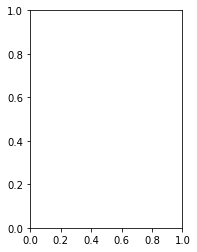

In [50]:
@interact(i = (0,252))
def plot_pp(i = 18):
    plt.clf()
    plt.subplot(121)
    plt.imshow(psth_[:,i,:],aspect = 'auto')
    plt.clim([0, 1])
    plt.ylim([0,5000])
    plt.subplot(122)
    plt.bar(temps,np.mean(psth_[:,i,:],0),temps[1]-temps[0])

In [321]:
%matplotlib qt

In [386]:
np.max(metaall.surprise)

36.04365338911715

In [387]:
a = sns.violinplot((metaall.surprise[(metaall.Region == 'Hpc') & (metaall.Type == 'Pyr')]))
# plt.hist((metaall.surprise[(metaall.Region == 'Hpc') & (metaall.Type == 'Pyr')]),200)

/home/billel/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [388]:
a

<AxesSubplot:xlabel='surprise'>

In [361]:
# sns.violnplot(metaall[(metaall['Region'] != 'None') & (metaall.Type == 'Int') ]['Region'],metaall[(metaall['Region'] != 'None') & (metaall.Type == 'Int')]['surprise'])


sns.violinplot(metaall.Region[(metaall.Region !='None') & (metaall.Type == 'Int')], metaall.surprise[(metaall.Region !='None') & (metaall.Type == 'Int')],scale = 'width')


plt.savefig('violin-suprise-int.svg')

/home/billel/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [27]:
%matplotlib qt

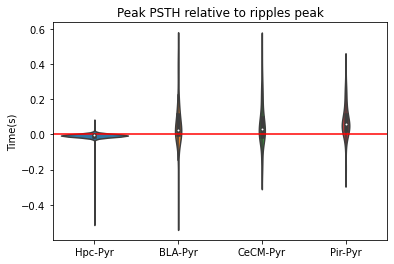

In [111]:
for key in peak_times:
    print(key,np.mean(peak_times[key]))

Hpc-Pyr -0.007802898550724639
BLA-Pyr 0.05733018867924529
CeCM-Pyr 0.05796875
Pir-Pyr 0.07450980392156863


In [122]:
scipy.stats.ttest_ind(peak_times['BLA-Pyr'],peak_times['Hpc-Pyr'])

Ttest_indResult(statistic=10.778088211902123, pvalue=2.253683476150369e-25)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

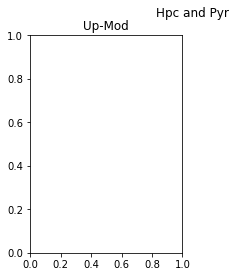

In [44]:
stru = np.unique(metaall.Region)
types = ['Pyr','Int']
stru = ['Hpc','BLA']
for s,t in itertools.product(stru,types):
    mask = (metaall.pInc < 0.001) & (metaall.Region == s) & (metaall.Type == t)
    mask = list(mask)
    
    psth_stru_types_u = np.nanmean(psthall[:,np.where(mask)[0]],1)
    
    mask = (metaall.pDec < 0.001) & (metaall.Region == s) & (metaall.Type == t)
    mask = list(mask)
    psth_stru_types_d = np.nanmean(psthall[:,np.where(mask)[0]],1)
    
    plt.figure()
    
    plt.suptitle(f'{s} and {t}')
    
    plt.subplot(1,2,1)
    plt.title('Up-Mod')
    plt.bar(temps,psth_stru_types_u,0.002,alpha = 0.5)
    plt.axvline(0,color = 'r',alpha = 0.5)
    
    plt.xlim(-0.5,0.5)
    
    plt.subplot(1,2,2)
    plt.title('Down-Mod')
    plt.bar(temps,psth_stru_types_d,0.002,alpha = 0.5)
    plt.axvline(0,color = 'r',alpha = 0.5)
    plt.xlim(-0.5,0.5)

    
    plt.tight_layout()
#     save_fig('P:/Data/Figures/',f'{s}-{t}-0.002-full.svg')
#     save_fig('P:/Data/Figures/',f'{s}-{t}-0.002-full.png')
    